<a href="https://colab.research.google.com/github/Pstar7s/Machine_Learninng_IoT_BoT/blob/master/06_Final_Max_Effort_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =================================================================
# NOTEBOOK FINAL UNTUK EKSEKUSI MAKSIMAL DI COLAB DENGAN TPU
# =================================================================

# SEL 1: IMPORT LIBRARY & INISIALISASI TPU
import pandas as pd
import numpy as np
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight

from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("✅ SEL 1: Semua library berhasil diimpor.")

# --- Inisialisasi Strategi TPU ---
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("✅ Strategi TPU berhasil diinisialisasi.")
else:
    strategy = tf.distribute.get_strategy()
    print("✅ Menjalankan dengan strategi default (CPU/GPU).")

✅ SEL 1: Semua library berhasil diimpor.
✅ Menjalankan dengan strategi default (CPU/GPU).


In [3]:
# =================================================================
# SEL 2: MEMUAT DAN MEMPROSES DATA
# =================================================================
print("\n--- SEL 2: Memuat dan Memproses Data ---")
RANDOM_STATE = 42
try:
    df = pd.read_csv('representative_sample.csv', low_memory=False)
    print("✅ Data sampel representatif berhasil dimuat.")
    print(f"   Ukuran data: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: File 'representative_sample.csv' tidak ditemukan. Pastikan Anda sudah mengunggahnya ke sesi Colab.")
    exit()

# --- Pra-pemrosesan ---
high_cardinality_cols = ['saddr', 'daddr', 'smac', 'dmac', 'sport', 'dport']
target_cols = ['category', 'subcategory', 'attack']
categorical_features = ['flgs', 'proto', 'state']

df.drop(columns=high_cardinality_cols, inplace=True, errors='ignore')
df.fillna(0, inplace=True)
df_processed = pd.get_dummies(df, columns=categorical_features, dtype=int)

X = df_processed.drop(columns=target_cols, errors='ignore')
le = LabelEncoder()
y = le.fit_transform(df_processed['category'])

object_cols_in_X = X.select_dtypes(include=['object']).columns
if len(object_cols_in_X) > 0:
    X = X.drop(columns=object_cols_in_X)

numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
if 'pkSeqID' in numeric_cols:
    numeric_cols.remove('pkSeqID')

scaler_supervised = StandardScaler()
X[numeric_cols] = scaler_supervised.fit_transform(X[numeric_cols])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print("\n✅ Pra-pemrosesan selesai. Data siap untuk pemodelan.")


--- SEL 2: Memuat dan Memproses Data ---
✅ Data sampel representatif berhasil dimuat.
   Ukuran data: (2199475, 35)

✅ Pra-pemrosesan selesai. Data siap untuk pemodelan.


In [4]:
# =================================================================
# SEL 3: PELATIHAN MODEL 1 - LIGHTGBM (VERSI DITINGKATKAN)
# =================================================================
print("\n--- SEL 3: Melatih Model LightGBM (Ditingkatkan) ---")
# Meningkatkan n_estimators untuk model yang lebih kuat
lgbm = LGBMClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
print("✅ Pelatihan dan evaluasi LightGBM selesai.")


--- SEL 3: Melatih Model LightGBM (Ditingkatkan) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3868
[LightGBM] [Info] Number of data points in the train set: 1539632, number of used features: 37
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

In [5]:
# =================================================================
# SEL 4: PELATIHAN MODEL 2 - ISOLATION FOREST
# =================================================================
print("\n--- SEL 4: Melatih Model Isolation Forest ---")
X_train_if = X_train.select_dtypes(include=np.number)
X_test_if = X_test.select_dtypes(include=np.number)
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=RANDOM_STATE)
iso_forest.fit(X_train_if)
y_pred_if_raw = iso_forest.predict(X_test_if)
print("✅ Pelatihan dan prediksi Isolation Forest selesai.")


--- SEL 4: Melatih Model Isolation Forest ---
✅ Pelatihan dan prediksi Isolation Forest selesai.


In [6]:
# =================================================================
# SEL 5: PELATIHAN MODEL 3 - AUTOENCODER (VERSI DITINGKATKAN)
# =================================================================
print("\n--- SEL 5: Melatih Model Autoencoder (Ditingkatkan) ---")
normal_label_numeric = le.transform(['Normal'])[0]
X_train_normal_unscaled = X.loc[X_train.index][y_train == normal_label_numeric]

scaler_autoencoder = StandardScaler()
X_train_normal_scaled = scaler_autoencoder.fit_transform(X_train_normal_unscaled)

# Definisikan dan kompilasi model di dalam scope strategi TPU
with strategy.scope():
    input_dim = X_train_normal_scaled.shape[1]
    # Arsitektur lebih dalam
    autoencoder = Sequential([
        Dense(input_dim, activation='relu', input_shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

print("⏳ Melatih Autoencoder di TPU...")
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100, # Lebih banyak epoch
    batch_size=128 * strategy.num_replicas_in_sync,
    shuffle=True, validation_split=0.2,
    callbacks=[early_stopping], verbose=0
)
print("✅ Pelatihan Autoencoder selesai.")

manual_threshold = 0.2
print(f"⏳ Mengevaluasi Autoencoder dengan threshold = {manual_threshold}...")
X_test_scaled_for_ae = scaler_autoencoder.transform(X_test)
reconstructions = autoencoder.predict(X_test_scaled_for_ae, batch_size=2048)
test_loss = np.mean(np.square(X_test_scaled_for_ae - reconstructions), axis=1)
y_pred_ae_raw = (test_loss > manual_threshold).astype(int)
y_test_binary = (y_test != normal_label_numeric).astype(int)
print("✅ Evaluasi Autoencoder selesai.")


--- SEL 5: Melatih Model Autoencoder (Ditingkatkan) ---
⏳ Melatih Autoencoder di TPU...
✅ Pelatihan Autoencoder selesai.
⏳ Mengevaluasi Autoencoder dengan threshold = 0.2...
323/323 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
✅ Evaluasi Autoencoder selesai.


In [7]:
# =================================================================
# SEL 6: PELATIHAN MODEL 4 - LSTM (PENDEKATAN OVERSAMPLING)
# =================================================================
print("\n--- SEL 6: Melatih Model LSTM (Pendekatan Oversampling) ---")
y_train_binary = (y_train != normal_label_numeric).astype(int)

# --- STRATEGI BARU: OVERSAMPLING ---
# Dapatkan indeks untuk setiap kelas di data latihan
normal_indices_train = np.where(y_train_binary == 0)[0]
anomaly_indices_train = np.where(y_train_binary == 1)[0]

# Tentukan berapa kali kita perlu menduplikasi data normal
# Kita ingin jumlah data normal sekitar 25% dari data anomali
target_normal_count = int(len(anomaly_indices_train) * 0.25)
oversample_factor = int(np.ceil(target_normal_count / len(normal_indices_train)))

# Duplikasi indeks data normal
oversampled_normal_indices = np.tile(normal_indices_train, oversample_factor)

# Gabungkan indeks anomali dengan indeks normal yang sudah di-oversample
balanced_indices = np.concatenate([oversampled_normal_indices, anomaly_indices_train])
np.random.shuffle(balanced_indices)

# Buat set latihan baru yang lebih seimbang
X_train_balanced = X_train.iloc[balanced_indices]
y_train_balanced = y_train_binary[balanced_indices]
print(f"✅ Set latihan baru (oversampled) telah dibuat dengan {len(X_train_balanced)} sampel.")
# --- AKHIR STRATEGI BARU ---

X_train_lstm = np.reshape(X_train_balanced.values, (X_train_balanced.shape[0], 1, X_train_balanced.shape[1]))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Definisikan dan kompilasi model di dalam scope strategi TPU
with strategy.scope():
    num_features = X_train_lstm.shape[2]
    # Arsitektur lebih dalam
    lstm_model_binary = Sequential([
        LSTM(128, input_shape=(1, num_features), return_sequences=True), Dropout(0.3),
        LSTM(64, return_sequences=False), Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    lstm_model_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("⏳ Melatih LSTM di TPU pada data oversampled...")
early_stopping_lstm = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lstm_model_binary.fit(
    X_train_lstm, y_train_balanced,
    epochs=30,
    batch_size=1024 * strategy.num_replicas_in_sync, # Batch size sangat besar untuk TPU
    validation_data=(X_test_lstm[:100000], y_test_binary[:100000]),
    callbacks=[early_stopping_lstm], verbose=1
)
print("✅ Pelatihan LSTM selesai.")

print("⏳ Mengevaluasi LSTM...")
y_pred_lstm_proba = lstm_model_binary.predict(X_test_lstm, batch_size=2048)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int).flatten()
print("✅ Evaluasi LSTM selesai.")


--- SEL 6: Melatih Model LSTM (Pendekatan Oversampling) ---
✅ Set latihan baru (oversampled) telah dibuat dengan 1924442 sampel.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


⏳ Melatih LSTM di TPU pada data oversampled...
Epoch 1/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 110s 57ms/step - accuracy: 0.7961 - loss: 0.5078 - val_accuracy: 0.9999 - val_loss: 0.2420
Epoch 2/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.7999 - loss: 0.5009 - val_accuracy: 0.9999 - val_loss: 0.2324
Epoch 3/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.8001 - loss: 0.5003 - val_accuracy: 0.9999 - val_loss: 0.2313
Epoch 4/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.7997 - loss: 0.5009 - val_accuracy: 0.9999 - val_loss: 0.2342
Epoch 5/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 106s 56ms/step - accuracy: 0.7992 - loss: 0.5016 - val_accuracy: 0.9999 - val_loss: 0.2310
Epoch 6/30
1880/1880 ━━━━━━━━━━━━━━━━━━━━ 105s 56ms/step - accuracy: 0.7999 - loss: 0.5006 - val_accuracy: 0.9999 - val_loss: 0.2457
✅ Pelatihan LSTM selesai.
⏳ Mengevaluasi LSTM...
323/323 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step
✅ Evaluasi LSTM selesai.



--- SEL 7: Fusi Keputusan dan Evaluasi Akhir ---
✅ Fusi keputusan selesai.


           HASIL AKHIR UNTUK DOKUMENTASI PAPER

--- Laporan Klasifikasi Final untuk Model HIBRIDA ---
              precision    recall  f1-score   support

      Normal     0.9434    0.5747    0.7143        87
     Anomaly     0.9999    1.0000    1.0000    659756

    accuracy                         0.9999    659843
   macro avg     0.9717    0.7874    0.8571    659843
weighted avg     0.9999    0.9999    0.9999    659843



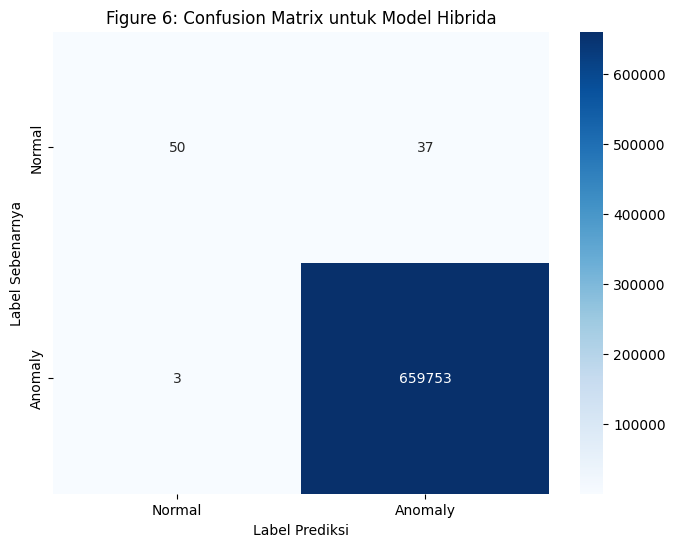

✅ Figure 6 (Confusion Matrix Hibrida) telah disimpan.


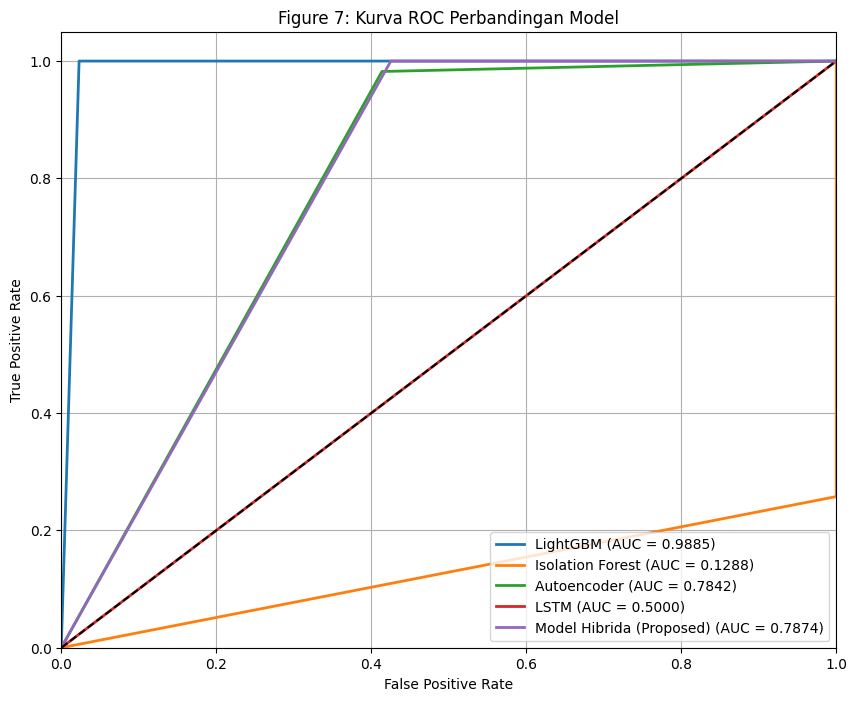

✅ Figure 7 (Kurva ROC) telah disimpan.


--- EKSEKUSI SELESAI ---


In [8]:
# =================================================================
# SEL 7: FUSI KEPUTUSAN DAN EVALUASI AKHIR
# =================================================================
print("\n--- SEL 7: Fusi Keputusan dan Evaluasi Akhir ---")

pred_lgbm_binary = (y_pred_lgbm != normal_label_numeric).astype(int)
pred_if_binary = np.where(y_pred_if_raw == -1, 1, 0)
pred_ae_binary = y_pred_ae_raw
pred_lstm_binary = y_pred_lstm

weight_lgbm = 1.0; weight_if = 0.5; weight_ae = 1.2; weight_lstm = 1.5
weighted_sum = (pred_lgbm_binary * weight_lgbm +
                pred_if_binary * weight_if +
                pred_ae_binary * weight_ae +
                pred_lstm_binary * weight_lstm)
fusion_threshold = 2.0
y_pred_hybrid = (weighted_sum > fusion_threshold).astype(int)
print("✅ Fusi keputusan selesai.")

print("\n\n============================================================")
print("           HASIL AKHIR UNTUK DOKUMENTASI PAPER")
print("============================================================")

print("\n--- Laporan Klasifikasi Final untuk Model HIBRIDA ---")
print(classification_report(y_test_binary, y_pred_hybrid, target_names=['Normal', 'Anomaly'], digits=4))

cm_hybrid = confusion_matrix(y_test_binary, y_pred_hybrid)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Figure 6: Confusion Matrix untuk Model Hibrida')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.savefig('figure_6_hybrid_confusion_matrix.png')
plt.show()
print("✅ Figure 6 (Confusion Matrix Hibrida) telah disimpan.")

plt.figure(figsize=(10, 8))
def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')

plot_roc_curve(y_test_binary, pred_lgbm_binary, 'LightGBM')
plot_roc_curve(y_test_binary, pred_if_binary, 'Isolation Forest')
plot_roc_curve(y_test_binary, pred_ae_binary, 'Autoencoder')
plot_roc_curve(y_test_binary, pred_lstm_binary, 'LSTM')
plot_roc_curve(y_test_binary, y_pred_hybrid, 'Model Hibrida (Proposed)')

plt.plot([0, 1], [0, 1], 'k--'); plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Figure 7: Kurva ROC Perbandingan Model'); plt.legend(loc="lower right"); plt.grid(True)
plt.savefig('figure_7_roc_curves.png')
plt.show()
print("✅ Figure 7 (Kurva ROC) telah disimpan.")

print("\n\n--- EKSEKUSI SELESAI ---")
